In [1]:
import csv
import itertools
from matplotlib import pyplot as plt
import numpy as np
import random

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# import warnings
# warnings.filterwarnings("ignore")

### Read the data

Note about the data: The dataset is rather large, and very skewed toward valid transactions. To balance it a bit better, we sample and only keep around 5% of the valid transactions (the 

In [2]:
with open('creditcard.csv', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    csv_data = list(reader)[1:]
    
csv_data = [row for row in csv_data if int(row[-1]) == 1 or random.random() < .05]

# Format: Time, V1, ..., V28, Amount, Class
data = np.array([[float(x) for x in row[1:-1]] for row in csv_data])
times = np.array([float(row[0]) for row in csv_data])
labels = np.array([int(row[-1]) for row in csv_data])
print('The data is imbalanced, with {} samples in total but only {} cases of fraud'.format(len(labels), sum(labels)))

The data is imbalanced, with 14753 samples in total but only 492 cases of fraud


### Feature Scaling

In [3]:
print(np.mean(data, axis=0))
print(np.var(data, axis=0))
print('The PCA features have mean 0 but different variances')
print('The transaction amount is not scaled. We should scale it so it does not affect the SVM too much')

[-1.71509701e-01  1.14883613e-01 -2.23337111e-01  1.46039243e-01
 -8.86846563e-02 -4.14206014e-02 -1.70273613e-01  1.63854599e-02
 -9.61740652e-02 -1.75920588e-01  1.17219737e-01 -2.06876287e-01
 -1.32585958e-03 -2.33277979e-01 -6.26666722e-03 -1.26621898e-01
 -2.06083862e-01 -7.59872808e-02  2.51322178e-02  2.70150806e-02
  2.48735349e-02  1.01485880e-02  5.33243455e-04 -8.32212611e-03
 -3.48668130e-03  9.30346487e-04  3.47527085e-03  4.10286201e-03
  9.15060089e+01]
[5.70120561e+00 3.47311615e+00 5.36177891e+00 2.86088412e+00
 3.01021483e+00 1.89777117e+00 4.01349245e+00 3.01027852e+00
 1.56588721e+00 2.93166759e+00 1.68906618e+00 2.87788205e+00
 1.00048107e+00 2.97624829e+00 8.45542440e-01 1.74409195e+00
 3.62694073e+00 1.11852630e+00 7.38510811e-01 5.77811922e-01
 1.02907114e+00 5.91302042e-01 4.62185951e-01 3.66085204e-01
 2.81665897e-01 2.28227666e-01 2.03689041e-01 9.93289080e-02
 6.11538809e+04]
The PCA features have mean 0 but different variances
The transaction amount is not 

In [4]:
scaler = StandardScaler()
data_sc = scaler.fit_transform(data)
print(np.mean(data_sc, axis=0))
print(np.var(data_sc, axis=0))

[-5.54603547e-17  3.79566386e-16  3.34842903e-16  1.24575557e-16
 -2.46975332e-16  4.98294703e-17 -1.01245766e-15  6.87690338e-17
  1.19473332e-16 -3.45182810e-16 -4.47968556e-16 -1.02306002e-16
  2.00431641e-16 -3.03631285e-17  9.98229945e-16  2.23245848e-16
 -9.50241377e-16  8.75430383e-17 -2.64292230e-17  2.42694317e-18
 -2.26270120e-17 -1.30050289e-16 -1.31517273e-16  2.37351279e-17
  1.10427795e-16  8.54585011e-17 -1.83245497e-16 -7.72379366e-17
  8.24251796e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


### Preliminary plotting

[ 1.09552461  1.03837033 -0.29124116 -0.3437115  -0.59193265  0.69350299
 -0.43321149  1.32177832 -0.91359973]


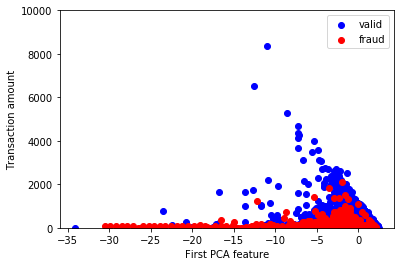

In [5]:
# plot the first two principal components
data_fraud = data[np.where(labels == 1)]
data_valid = data[np.where(labels == 0)]
plt.scatter(data_valid[:, 0], data_valid[:, -1], c='b')
plt.scatter(data_fraud[:, 0], data_fraud[:, -1], c='r')
print(data_valid[1:10, 0])
plt.ylim((0, 10000))
plt.legend(['valid', 'fraud'])
plt.xlabel('First PCA feature')
plt.ylabel('Transaction amount')
plt.show()

### Setting up cross-validation

In [6]:
fraud_indices = np.where(labels == 1)[0]
np.random.shuffle(fraud_indices)
fraud_splits = np.array_split(fraud_indices, 5)

valid_indices = np.where(labels == 0)[0]
np.random.shuffle(valid_indices)
valid_splits = np.array_split(valid_indices, 5)

folds = [np.concatenate((fraud_sp, valid_sp)) for fraud_sp, valid_sp in zip(fraud_splits, valid_splits)]

### SVM

In [7]:
def train_binary_SVM(data, scale=False, kernel=None, class_weight=None):
    confusion_mat = np.zeros((2, 2))
    for i in range(5):
        if kernel is None:
            if class_weight is None:
                svm = LinearSVC(fit_intercept=False, dual=False)
            else:
                svm = LinearSVC(fit_intercept=False, dual=False, class_weight=class_weight)
        else:
            if class_weight is None:
                svm = SVC(kernel=kernel, gamma='auto')
            else:
                svm = SVC(kernel=kernel, gamma='auto', class_weight=class_weight)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        svm.fit(train_data, np.delete(labels, folds[i]))
        pred = svm.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        print('Fold', i)
        print(conf_mat)

        confusion_mat += conf_mat

    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    print('False negatives (valid):', confusion_mat[0, 1] / sum(confusion_mat[0, :]))
    print('False positives (fraud):', confusion_mat[1, 0] / sum(confusion_mat[1,:]))
    return confusion_mat

#### Linear SVM -- Without scaling or class weights

In [8]:
train_binary_SVM(data);

Fold 0
[[2848    5]
 [  19   80]]
Fold 1
[[2845    7]
 [  23   76]]
Fold 2
[[2844    8]
 [  23   75]]
Fold 3
[[2839   13]
 [  17   81]]
Fold 4
[[2843    9]
 [  22   76]]
Final Confusion Matrix
[[2843.8    8.4]
 [  20.8   77.6]]
False negatives (valid): 0.0029450950143748685
False positives (fraud): 0.21138211382113822


#### Linear SVM with Scaling

In [9]:
train_binary_SVM(data, scale=True);

Fold 0
[[2849    4]
 [  17   82]]
Fold 1
[[2841   11]
 [  19   80]]
Fold 2
[[2843    9]
 [  15   83]]
Fold 3
[[2848    4]
 [  15   83]]
Fold 4
[[2840   12]
 [  16   82]]
Final Confusion Matrix
[[2844.2    8. ]
 [  16.4   82. ]]
False negatives (valid): 0.002804852394642732
False positives (fraud): 0.16666666666666663


#### Linear SVM with Scaling and Class Weights

In [10]:
train_binary_SVM(data, scale=True, class_weight='balanced');

Fold 0
[[2754   99]
 [   9   90]]
Fold 1
[[2731  121]
 [  11   88]]
Fold 2
[[2712  140]
 [   8   90]]
Fold 3
[[2750  102]
 [   5   93]]
Fold 4
[[2695  157]
 [   5   93]]
Final Confusion Matrix
[[2728.4  123.8]
 [   7.6   90.8]]
False negatives (valid): 0.04340509080709627
False positives (fraud): 0.07723577235772358


### Kernel SVM

#### RBF Kernel with Scaling and Class Weights

In [11]:
train_binary_SVM(data, scale=True, kernel='rbf');

Fold 0
[[2853    0]
 [  19   80]]
Fold 1
[[2849    3]
 [  22   77]]
Fold 2
[[2852    0]
 [  23   75]]
Fold 3
[[2849    3]
 [  19   79]]
Fold 4
[[2849    3]
 [  23   75]]
Final Confusion Matrix
[[2.8504e+03 1.8000e+00]
 [2.1200e+01 7.7200e+01]]
False negatives (valid): 0.0006310917887946147
False positives (fraud): 0.2154471544715447


In [12]:
train_binary_SVM(data, kernel='rbf', class_weight='balanced');

Fold 0
[[2843   10]
 [  43   56]]
Fold 1
[[2842   10]
 [  42   57]]
Fold 2
[[2837   15]
 [  51   47]]
Fold 3
[[2841   11]
 [  49   49]]
Fold 4
[[2841   11]
 [  50   48]]
Final Confusion Matrix
[[2840.8   11.4]
 [  47.    51.4]]
False negatives (valid): 0.003996914662365893
False positives (fraud): 0.4776422764227642


#### Polynomial Kernel with Scaling and Class Weights

In [13]:
train_binary_SVM(data, scale=True, kernel='poly');

Fold 0
[[2851    2]
 [  18   81]]
Fold 1
[[2850    2]
 [  19   80]]
Fold 2
[[2850    2]
 [  17   81]]
Fold 3
[[2846    6]
 [  21   77]]
Fold 4
[[2843    9]
 [  18   80]]
Final Confusion Matrix
[[2848.     4.2]
 [  18.6   79.8]]
False negatives (valid): 0.0014725475071874345
False positives (fraud): 0.18902439024390244


In [14]:
train_binary_SVM(data, scale=True, kernel='poly', class_weight='balanced');

Fold 0
[[2849    4]
 [  15   84]]
Fold 1
[[2823   29]
 [  18   81]]
Fold 2
[[2833   19]
 [  13   85]]
Fold 3
[[2832   20]
 [  13   85]]
Fold 4
[[2823   29]
 [   9   89]]
Final Confusion Matrix
[[2832.    20.2]
 [  13.6   84.8]]
False negatives (valid): 0.007082252296472898
False positives (fraud): 0.13821138211382114


### Logistic Regression

In [15]:
def train_logistic_regression(data, class_weight = None, C=1.0):
    err = 0
    err_valid = 0
    err_fraud = 0
    confusion_mat = np.zeros((2, 2))
    AU = 0
    for i in range(5):
        model = LogisticRegression(class_weight=class_weight, C=C)
        
        model.fit(np.delete(data, folds[i], axis=0), np.delete(labels, folds[i]))
        pred = model.predict(data[folds[i]])
        pred1 = model.predict_proba(data[folds[i]])[:,1]
        #err_fold = np.sum((pred - labels[folds[i]])**2) / len(folds[i])
        #pred_valid = model.predict(data[valid_splits[i]])
        #err_valid_fold = np.sum((pred_valid - labels[valid_splits[i]])**2) / len(valid_splits[i])
        #pred_fraud = model.predict(data[fraud_splits[i]])
        #err_fraud_fold = np.sum((pred_fraud - labels[fraud_splits[i]])**2) / len(fraud_splits[i])
        #print('Fold', i, 'Error:', err_fold, 'Valid Error:', err_valid_fold, 'Fraud Error', err_fraud_fold)
        #err += err_fold
        #err_valid += err_valid_fold
        #err_fraud += err_fraud_fold
        conf_mat = confusion_matrix(labels[folds[i]], pred)
        fpr, tpr, thresholds = roc_curve(labels[folds[i]], pred1)
        area_under_curve = auc(fpr, tpr)
        AU += area_under_curve
        print('Fold', i)
        print(conf_mat)
        print('Area under curve:', area_under_curve)

        confusion_mat += conf_mat
    AU/=5
    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    return confusion_mat, AU
    #err /= 5
    #err_valid /= 5
    #err_fraud /= 5
    #print('FINAL Error:', err, 'Valid Error:', err_valid, 'Fraud Error', err_fraud)
    #return err, err_valid, err_fraud

#### Logistic Regression with Scaling, Class Weights, and Regularization

In [16]:
weights = [None,'balanced']
coefficients = np.logspace(-2,0,10)
fscore = []
recall = []
precision = []
AU = []
param_permuations = list(itertools.product(weights, coefficients))
for cw,C in param_permuations:
    print('Checking class weight {} and coefficient {}'.format(cw, C))
    cf,au = train_logistic_regression(data_sc, cw, C)
    TP = cf[1][1]
    FP = cf[0][1]
    FN = cf[1][0]
    prec = TP/(TP+FP)
    rec = TP/(TP+FN)
    f1 = prec*rec*2/(prec+rec)
    print('F1 score:', f1)
    print('Recall:', rec)
    print('Precision:', prec)
    print('AUC:', au)
    fscore.append(f1)
    recall.append(rec)
    precision.append(prec)
    AU.append(au)

idx = np.argmax(AU)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under AUC metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(f1)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under F1 metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(precision)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under precision metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(recall)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under recall metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

Checking class weight None and coefficient 0.01
Fold 0
[[2852    1]
 [  19   80]]
Area under curve: 0.9805839679656714
Fold 1
[[2848    4]
 [  19   80]]
Area under curve: 0.9623974669556717
Fold 2
[[2852    0]
 [  18   80]]
Area under curve: 0.9824970661476372
Fold 3
[[2849    3]
 [  15   83]]
Area under curve: 0.9830087013767639
Fold 4
[[2848    4]
 [  19   79]]
Area under curve: 0.9922682256633367
Final Confusion Matrix
[[2.8498e+03 2.4000e+00]
 [1.8000e+01 8.0400e+01]]
F1 score: 0.8874172185430463
Recall: 0.8170731707317074
Precision: 0.9710144927536232
AUC: 0.9801510856218162
Checking class weight None and coefficient 0.016681005372000592
Fold 0
[[2852    1]
 [  19   80]]
Area under curve: 0.978796021908535
Fold 1
[[2848    4]
 [  19   80]]
Area under curve: 0.9636229050675055
Fold 2
[[2852    0]
 [  16   82]]
Area under curve: 0.983126771045024
Fold 3
[[2849    3]
 [  15   83]]
Area under curve: 0.9830265907204395
Fold 4
[[2847    5]
 [  19   79]]
Area under curve: 0.9926975699115

Fold 0
[[2800   53]
 [  10   89]]
Area under curve: 0.9693110565876076
Fold 1
[[2782   70]
 [  14   85]]
Area under curve: 0.967090257412838
Fold 2
[[2788   64]
 [  10   88]]
Area under curve: 0.9805256604745686
Fold 3
[[2792   60]
 [   6   92]]
Area under curve: 0.9808154678421157
Fold 4
[[2780   72]
 [   6   92]]
Area under curve: 0.9904900249019664
Final Confusion Matrix
[[2788.4   63.8]
 [   9.2   89.2]]
F1 score: 0.709626093874304
Recall: 0.9065040650406504
Precision: 0.5830065359477125
AUC: 0.9776464934438192
Checking class weight balanced and coefficient 0.1291549665014884
Fold 0
[[2800   53]
 [  10   89]]
Area under curve: 0.968695011807525
Fold 1
[[2779   73]
 [  14   85]]
Area under curve: 0.9672177596441272
Fold 2
[[2787   65]
 [  10   88]]
Area under curve: 0.9803575006440164
Fold 3
[[2792   60]
 [   6   92]]
Area under curve: 0.9808691358731431
Fold 4
[[2780   72]
 [   6   92]]
Area under curve: 0.9902467298279761
Final Confusion Matrix
[[2787.6   64.6]
 [   9.2   89.2]]
F

# kNN

In [17]:
def train_KNN(data, k, scale=False):
    confusion_mat = np.zeros((2, 2))
    for i in range(5):
        knn = KNeighborsClassifier(n_neighbors=k)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        knn.fit(train_data, np.delete(labels, folds[i]))
        pred = knn.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        print('Fold', i)
        print(conf_mat)

        confusion_mat += conf_mat

    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    print('False negatives (valid):', confusion_mat[0, 1] / sum(confusion_mat[0, :]))
    print('False positives (fraud):', confusion_mat[1, 0] / sum(confusion_mat[1,:]))
    return confusion_mat

In [18]:
for k in [5, 7, 9, 11]:
    conf = train_KNN(data, k)
    print('Confusion Matrix:')
    print(conf)
    print()

Fold 0
[[2852    1]
 [  28   71]]
Fold 1
[[2847    5]
 [  24   75]]
Fold 2
[[2852    0]
 [  31   67]]
Fold 3
[[2848    4]
 [  29   69]]
Fold 4
[[2848    4]
 [  29   69]]
Final Confusion Matrix
[[2.8494e+03 2.8000e+00]
 [2.8200e+01 7.0200e+01]]
False negatives (valid): 0.000981698338124956
False positives (fraud): 0.2865853658536585
Confusion Matrix:
[[2.8494e+03 2.8000e+00]
 [2.8200e+01 7.0200e+01]]

Fold 0
[[2852    1]
 [  33   66]]
Fold 1
[[2846    6]
 [  26   73]]
Fold 2
[[2852    0]
 [  31   67]]
Fold 3
[[2850    2]
 [  32   66]]
Fold 4
[[2848    4]
 [  31   67]]
Final Confusion Matrix
[[2.8496e+03 2.6000e+00]
 [3.0600e+01 6.7800e+01]]
False negatives (valid): 0.000911577028258888
False positives (fraud): 0.31097560975609756
Confusion Matrix:
[[2.8496e+03 2.6000e+00]
 [3.0600e+01 6.7800e+01]]

Fold 0
[[2852    1]
 [  35   64]]
Fold 1
[[2847    5]
 [  27   72]]
Fold 2
[[2851    1]
 [  36   62]]
Fold 3
[[2850    2]
 [  33   65]]
Fold 4
[[2848    4]
 [  37   61]]
Final Confusion Matri